## Compare ECCO and ERA5 net air-sea heat fluxes

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import cmocean
import matplotlib.pyplot as plt

Open ECCO heat flux data

In [2]:
# define root directory for location of all downloaded NetCDF files
root_dir = Path('../data/ECCO_V4r4_PODAAC')

# define the directory where the files specific to desired dataset are stored
nc_heat_dir = root_dir / "ECCO_L4_HEAT_FLUX_05DEG_MONTHLY_V4R4"

In [3]:
# get all files in each folder for import
heat_nc_files = list(nc_heat_dir.glob('*nc'))

In [4]:
# import 26 years of ecco heat flux data
heat_ds = xr.open_mfdataset(heat_nc_files, parallel=True, data_vars='minimal',\
                            coords='minimal', compat='override')

heat_ds

<xarray.Dataset>
Dimensions:         (time: 312, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T...
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EXFhl           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFhs           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswdn         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFqnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQnet         (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIatmQnt        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    TFLUX           (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFswnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    EXFlwnet        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    oceQsw          (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SIaaflux        (time, latitude, longitude) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            1992-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Ocean and Sea-Ice Surface Heat Fluxes ...
    uuid:                         73ea7d5c-4158-11eb-8d61-0cc47a3f812d

In [5]:
# isolate data for the western Labrador Sea
heat_Lab = heat_ds.sel(longitude=slice(-60,-51), latitude=slice(57,62))

In [13]:
# loop through each year and calculate winter season (Nov-Mar) heat fluxes
years = list(range(1992, 2017, 1))
ecco_winter_heat = pd.DataFrame({"start_year": years})
heat_winter = []

for year in years:
    # subset data from May-April (including winter season) months of consecutive years
    data_tmp = heat_Lab.SIatmQnt.sel(time=slice('05-'+str(year),'04-'+str(year+1)))
    # subset data from May-April (including winter season) months of consecutive years
    tmp = data_tmp.sel(time=slice('11-'+str(year),'03-'+str(year+1))).mean(dim=['time','latitude','longitude'])
    # take mean to get annual mean air-sea heat flux
    heat_winter.append(tmp.values)

ecco_winter_heat['Qnet_winter'] = heat_winter

print(ecco_winter_heat)

    start_year Qnet_winter
0         1992   193.31454
1         1993   212.65994
2         1994    287.1199
3         1995   159.46687
4         1996   213.44077
5         1997   231.93657
6         1998   254.11316
7         1999   275.22705
8         2000   224.78827
9         2001   293.35934
10        2002    223.0433
11        2003    271.5602
12        2004      288.49
13        2005   253.96547
14        2006   213.23203
15        2007    285.0688
16        2008   224.85423
17        2009   135.53424
18        2010    218.1352
19        2011   284.02942
20        2012   192.94806
21        2013   258.33987
22        2014   290.29868
23        2015   276.13705
24        2016    280.4503


Open ERA5 heat flux data

In [9]:
# inlcudes 1979-2021 variables: Surface net solar radiation, Surface net thermal radiation
solar_thermal = xr.load_dataset("../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_solar_thermal_heat.grib", engine='cfgrib')

Ignoring index file '../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_solar_thermal_heat.grib.923a8.idx' incompatible with GRIB file


In [10]:
# inlcudes 1979-2021 variables: Surface latent heat flux, Surface sensible heat flux
latent_sensible = xr.load_dataset("../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_latent_sensible_heat.grib", engine='cfgrib')

Ignoring index file '../data_climatology/era5_1m_1979to2021_50to90N_-120Wto40E_025025_latent_sensible_heat.grib.923a8.idx' incompatible with GRIB file


In [11]:
# The units are joules per square metre (J m^-2 ). 
# To convert to watts per square metre (W m^-2 ), the accumulated values should be divided by the accumulation period expressed in seconds.
# must divide values by 86,400 (sec/day)
Q_net = (solar_thermal.ssr/86400 + solar_thermal.str/86400 + latent_sensible.slhf/86400 + latent_sensible.sshf/86400)*(-1)

In [12]:
Q_net_Lab = Q_net.sel(time=slice("1992","2017"),longitude=slice(-60,-51),latitude=slice(62,57))

In [14]:
# loop through each year and calculate winter season (Nov-Mar) heat fluxes
years = list(range(1992, 2017, 1))
era5_winter_heat = pd.DataFrame({"start_year": years})
heat_winter = []

for year in years:
    # subset data from May-April (including winter season) months of consecutive years
    data_tmp = Q_net_Lab.sel(time=slice('05-'+str(year),'04-'+str(year+1)))
    # subset data from May-April (including winter season) months of consecutive years
    tmp = data_tmp.sel(time=slice('11-'+str(year),'03-'+str(year+1))).mean(dim=['time','latitude','longitude'])
    # take mean to get annual mean air-sea heat flux
    heat_winter.append(tmp.values)

era5_winter_heat['Qnet_winter'] = heat_winter

print(era5_winter_heat)

    start_year         Qnet_winter
0         1992   214.7735565424055
1         1993  226.15541392136183
2         1994  243.64055457540874
3         1995  180.37300596131846
4         1996   259.2703104220291
5         1997   224.8870347326493
6         1998  206.22954448794033
7         1999  202.82731383168883
8         2000  188.22208123003958
9         2001  245.04256660231655
10        2002  231.60005270821418
11        2003  217.13457695493113
12        2004   233.9366901291172
13        2005  183.82573941501025
14        2006  197.75618473682013
15        2007   235.8096853788312
16        2008  209.64131066632106
17        2009  127.65023754409171
18        2010  244.06597088457502
19        2011   215.5737963275776
20        2012   172.5535872330664
21        2013  267.06570796540586
22        2014   273.1487469686949
23        2015   215.1525225247569
24        2016  248.62772855742648


Compare ERA5 and ECCO winter heat fluxes

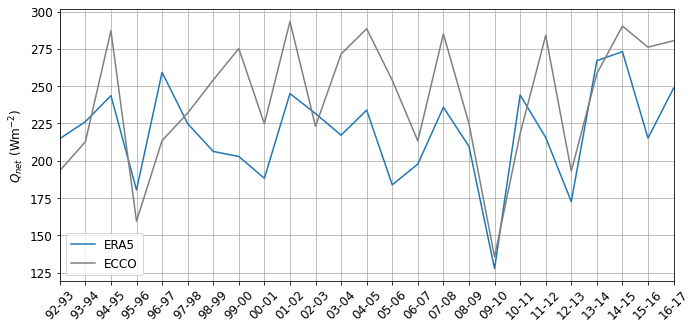

In [16]:
plt.figure(figsize=[11, 5])
plt.rcParams['font.size'] = '12'

plt.plot(era5_winter_heat.start_year,era5_winter_heat.Qnet_winter,color='tab:blue',label='ERA5')
plt.plot(ecco_winter_heat.start_year,ecco_winter_heat.Qnet_winter,color='tab:gray',label='ECCO')

# ticks
year_span = []
for year in winter_heat.start_year:
    year_span.append(str(year)[-2:]+'-'+str(year+1)[-2:])

plt.margins(x=0)
plt.ylabel("$Q_{net}$ (Wm$^{-2}$)")
plt.xticks(ticks=era5_winter_heat.start_year, labels=year_span, rotation=45)

plt.legend()
plt.grid();